# < 6. 영화리뷰 텍스트 감성분석하기 >

## [루브릭]
1. 다양한 방법으로 Text Classification 태스크를 성공적으로 구현하였다.
2. gensim을 활용하여 자체학습된 혹은 사전학습된 임베딩 레이어를 분석하였다.
3. 한국어 Word2Vec을 활용하여 가시적인 성능향상을 달성했다.

## [학습 목표]
- 텍스트 데이터를 머신러닝 입출력용 수치데이터로 변환하는 과정을 이해한다.
- RNN의 특징을 이해하고 시퀀셜한 데이터를 다루는 방법을 이해한다.
- 1-D CNN으로도 텍스트를 처리할 수 있음을 이해한다.
- 영화리뷰 감성 분류 실습을 진행한다.

---

In [1]:
import os
import re
import pandas as pd
import numpy as np

import urllib.request
import matplotlib.pyplot as plt
%matplotlib inline


from konlpy.tag import Okt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.initializers import Constant
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model


import gensim
from gensim.models import KeyedVectors
from gensim.models.keyedvectors import Word2VecKeyedVectors

## 1. 데이터 준비와 확인

In [2]:
train_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_test.txt')

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [3]:
test_data.head()

,id,document,label
0,6270596,굳 ㅋ,1
1,9274899,GDNTOPCLASSINTHECLUB,0
2,8544678,뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아,0
3,6825595,지루하지는 않은데 완전 막장임... 돈주고 보기에는....,0
4,6723715,3D만 아니었어도 별 다섯 개 줬을텐데.. 왜 3D로 나와서 제 심기를 불편하게 하죠??,0


---

## 2. 데이터로더 구성
- 데이터의 중복 제거
- NaN 결측치 제거
- 한국어 토크나이저로 토큰화
- 불용어(Stopwords) 제거
- 사전word_to_index 구성
- 텍스트 스트링을 사전 인덱스 스트링으로 변환
- X_train, y_train, X_test, y_test, word_to_index 리턴

In [4]:
from konlpy.tag import Mecab
import numpy as np
from collections import Counter

### Mecab
- 한글 형태소 분석기
- 형태소 분석이란 ? 형태소를 비롯하여, 어근, 접두사/접미사, 품사 등 다양한 언어적 속성의 구조를 파악하는 것

In [5]:
tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

In [6]:
def load_data(train_data, test_data, num_words=10000):
    
    # train data 전처리
    train_data.drop_duplicates(subset=['document'], inplace=True)
    train_data = train_data.dropna(how = 'any') 
    
    # test data 전처리
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how = 'any') 
    
    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_test.append(temp_X)
    
    # 단어 사전
    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4)
    vocab = ['<PAD>', '<BOS>', '<UNK>', '<UNUSED>'] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}
        
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist]
        
    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))
        
    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index 

### DataFrame.drop_duplicates(subset=None, keep='first', inplace=False)
- 중복 요소를 삭제하는 메서드
- series, dataframe, index 객체에 적용이 가능
- subset : 중복 데이터를 처리할 열을 입력받는다
- keep : 중복데이터 발견시 어떤 데이터를 마크할지 혹은 삭제할지 여부를 결정하는 변수
- inplace : 메서드가 적용되는 원본 데이터를 변경할지 여부를 결정

### dropna(how = 'any')
- NaN 값이 있는 데이터 제거
- how 
    - any : 1개라도 NaN값이 존재시 drop
    - all : 모두 NaN값이 존재시 drop

In [7]:
X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data) 

In [8]:
index_to_word = {index:word for word, index in word_to_index.items()}

In [9]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다. 
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

---

## 3. 모델 구성을 위한 데이터 분석 및 가공

In [10]:
print("훈련 샘플 개수: {}, 테스트 개수: {}".format(len(X_train), len(X_test)))

훈련 샘플 개수: 146182, 테스트 개수: 49157


In [11]:
print(get_decoded_sentence(X_train[0], index_to_word))
print('라벨: ', y_train[0])

더 빙 . . 진짜 짜증 나 네요 목소리
라벨:  0


### 데이터셋 내 문장 길이 분포

In [12]:
total_data_text = list(X_train) + list(X_test)

num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)

print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

문장길이 평균 :  15.96940191154864
문장길이 최대 :  116
문장길이 표준편차 :  12.843571191092


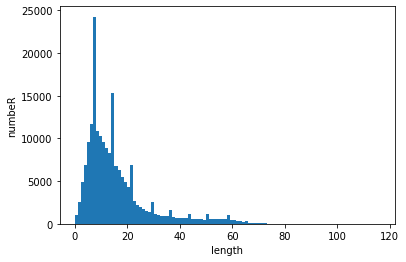

In [13]:
plt.clf()

plt.hist([len(s) for s in total_data_text], bins=100)
plt.xlabel('length')
plt.ylabel('numbeR')
plt.show()

### 적절한 최대 문장 길이 지정

In [14]:
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다. '.format(np.sum(num_tokens < max_tokens) / len(num_tokens)))

pad_sequences maxlen :  41
전체 문장의 0.9342988343341575%가 maxlen 설정값 이내에 포함됩니다. 


### 패딩 추가
- 데이터셋 상의 문장의 길이를 통일해야한다

In [15]:
X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train,
                                                        value=word_to_index["<PAD>"],
                                                        padding='post', # 혹은 'pre'
                                                        maxlen=maxlen)

X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test,
                                                       value=word_to_index["<PAD>"],
                                                       padding='post', # 혹은 'pre'
                                                       maxlen=maxlen)

print(X_train.shape)

(146182, 41)


### validation set 분리
- 훈련데이터셋의 20% 정도를 분할했다

In [16]:
# validation set 30000건 분리
X_val = X_train[:30000]   
y_val = y_train[:30000]

# validation set을 제외한 나머지
partial_X_train = X_train[30000:]  
partial_y_train = y_train[30000:]

In [17]:
print(X_val.shape)
print(y_val.shape)
print(partial_X_train.shape)
print(partial_y_train.shape)
print(X_test.shape)
print(y_test.shape)

(30000, 41)
(30000,)
(116182, 41)
(116182,)
(49157, 41)
(49157,)


---

## 4. 모델 설계와 훈련

In [18]:
vocab_size = 10000 
word_vector_dim = 16

### (1) LSTM
- Long Short -Term Memory
- RNN 중에서 가장 널리 쓰이는 모델
- 오래된 정보도 기억할 수 있는 long-term dependencies를 지니고 있다

#### 설계

In [19]:
lstm_model = tf.keras.Sequential()
lstm_model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
lstm_model.add(tf.keras.layers.LSTM(16))   # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용하였습니다. 
lstm_model.add(tf.keras.layers.Dense(8, activation='relu'))
lstm_model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

lstm_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          160000    
_________________________________________________________________
lstm (LSTM)                  (None, 16)                2112      
_________________________________________________________________
dense (Dense)                (None, 8)                 136       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 162,257
Trainable params: 162,257
Non-trainable params: 0
_________________________________________________________________


#### 학습

In [20]:
lstm_model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=10

history = lstm_model.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/10
227/227 [==============================] - 5s 7ms/step - loss: 0.5117 - accuracy: 0.7214 - val_loss: 0.3638 - val_accuracy: 0.8392
Epoch 2/10
227/227 [==============================] - 1s 5ms/step - loss: 0.3414 - accuracy: 0.8551 - val_loss: 0.3529 - val_accuracy: 0.8453
Epoch 3/10
227/227 [==============================] - 1s 5ms/step - loss: 0.3169 - accuracy: 0.8650 - val_loss: 0.3446 - val_accuracy: 0.8497
Epoch 4/10
227/227 [==============================] - 1s 5ms/step - loss: 0.3005 - accuracy: 0.8710 - val_loss: 0.3548 - val_accuracy: 0.8492
Epoch 5/10
227/227 [==============================] - 1s 6ms/step - loss: 0.2861 - accuracy: 0.8750 - val_loss: 0.3587 - val_accuracy: 0.8493
Epoch 6/10
227/227 [==============================] - 1s 5ms/step - loss: 0.2742 - accuracy: 0.8787 - val_loss: 0.3668 - val_accuracy: 0.8466
Epoch 7/10
227/227 [==============================] - 1s 6ms/step - loss: 0.2646 - accuracy: 0.8810 - val_loss: 0.3812 - val_accuracy: 0.8453
Epoch 

#### 결과

In [21]:
results = lstm_model.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 3s - loss: 0.4223 - accuracy: 0.8415
[0.42232003808021545, 0.841548502445221]


#### 그래프로 확인

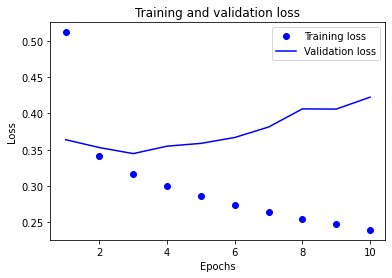

In [22]:
history_dict = history.history

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

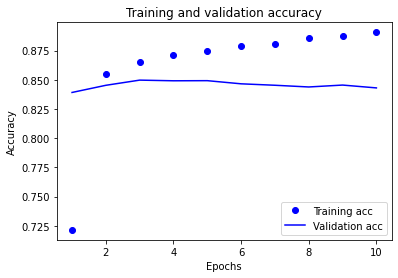

In [23]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

### Embedding layer

In [24]:
embedding_layer = lstm_model.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape) 

(10000, 16)


In [25]:
word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/word2vec.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
vectors = lstm_model.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [26]:
word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)

word_vectors.similar_by_word("사랑")

[('10', 0.9772783517837524),
 ('멋졌', 0.9368650913238525),
 ('발견', 0.933087170124054),
 ('레고', 0.9279651641845703),
 ('존경', 0.9207555055618286),
 ('백제', 0.9185996651649475),
 ('깊', 0.9185388088226318),
 ('해골', 0.9177293181419373),
 ('싸대', 0.9159510731697083),
 ('오묘', 0.9140459299087524)]

> 사랑이라는 단어랑 유사한 다른 단어들을 잘 찾았다고 생각되지 않는다

### 한국어 Word2Vec

In [18]:
word2vec_path = os.getenv('HOME')+'/aiffel/sentiment_classification/ko.bin'
word2vec = gensim.models.Word2Vec.load(word2vec_path)
vector = word2vec.wv['영화']
vector.shape

(200,)

In [19]:
word2vec.wv.similar_by_word("감동")

[('감명', 0.7177015542984009),
 ('감격', 0.6908231973648071),
 ('실망', 0.6267645359039307),
 ('감화', 0.6191877126693726),
 ('감탄', 0.6140128374099731),
 ('칭찬', 0.6059398055076599),
 ('존경', 0.6032299995422363),
 ('자극', 0.594598650932312),
 ('감복', 0.5902734994888306),
 ('호응', 0.5850393772125244)]

In [20]:
vocab_size = 10000
word_vector_dim = 200

embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

for i in range(4,vocab_size):
    if index_to_word[i] in word2vec.wv:
        embedding_matrix[i] = word2vec.wv[index_to_word[i]]

In [21]:
vocab_size = 10000
word_vector_dim = 200

lstm_ko = keras.Sequential()
lstm_ko.add(keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),
                                 input_length=maxlen, 
                                 trainable=True))
lstm_ko.add(keras.layers.LSTM(64))
lstm_ko.add(keras.layers.Dense(256, activation='relu'))
lstm_ko.add(keras.layers.Dense(1, activation='sigmoid'))

lstm_ko.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 41, 200)           2000000   
_________________________________________________________________
lstm (LSTM)                  (None, 64)                67840     
_________________________________________________________________
dense (Dense)                (None, 256)               16640     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 257       
Total params: 2,084,737
Trainable params: 2,084,737
Non-trainable params: 0
_________________________________________________________________


In [23]:
lstm_ko.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=10

history = lstm_ko.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/10
227/227 [==============================] - 6s 11ms/step - loss: 0.5673 - accuracy: 0.6716 - val_loss: 0.4144 - val_accuracy: 0.8129
Epoch 2/10
227/227 [==============================] - 2s 8ms/step - loss: 0.3668 - accuracy: 0.8388 - val_loss: 0.3407 - val_accuracy: 0.8516
Epoch 3/10
227/227 [==============================] - 2s 8ms/step - loss: 0.3083 - accuracy: 0.8696 - val_loss: 0.3288 - val_accuracy: 0.8584
Epoch 4/10
227/227 [==============================] - 2s 8ms/step - loss: 0.2792 - accuracy: 0.8834 - val_loss: 0.3452 - val_accuracy: 0.8550
Epoch 5/10
227/227 [==============================] - 2s 8ms/step - loss: 0.2521 - accuracy: 0.8969 - val_loss: 0.3312 - val_accuracy: 0.8610
Epoch 6/10
227/227 [==============================] - 2s 8ms/step - loss: 0.2315 - accuracy: 0.9068 - val_loss: 0.3375 - val_accuracy: 0.8590
Epoch 7/10
227/227 [==============================] - 2s 8ms/step - loss: 0.2122 - accuracy: 0.9146 - val_loss: 0.3507 - val_accuracy: 0.8577
Epoch

In [24]:
results = lstm_ko.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 3s - loss: 0.4176 - accuracy: 0.8520
[0.41764751076698303, 0.8520251512527466]


-------
-------

### (2) 1-D CNN(1-D Convolution Neural Network)
- 문장 전체를 한꺼번에 한 방향으로 길이 7짜리 필터로 스캐닝 하면서 7단어 이내에서 발견되는 특징을 추출하여 그것으로 문장을 분류하는 방식으로 사용
- CNN계열은 RNN계열보다 병렬처리가 효율적이기 때문에 학습 속도도 훨씬 빠름

#### 설계

In [25]:
dcnn_model = tf.keras.Sequential()
dcnn_model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
dcnn_model.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
dcnn_model.add(tf.keras.layers.MaxPooling1D(5))
dcnn_model.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
dcnn_model.add(tf.keras.layers.GlobalMaxPooling1D())
dcnn_model.add(tf.keras.layers.Dense(8, activation='relu'))
dcnn_model.add(tf.keras.layers.Dense(1, activation='sigmoid')) 

dcnn_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 200)         2000000   
_________________________________________________________________
conv1d (Conv1D)              (None, None, 16)          22416     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, None, 16)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 16)          1808      
_________________________________________________________________
global_max_pooling1d (Global (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                

#### 학습

In [26]:
dcnn_model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=10

history = dcnn_model.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/10
227/227 [==============================] - 4s 9ms/step - loss: 0.4497 - accuracy: 0.7859 - val_loss: 0.3437 - val_accuracy: 0.8507
Epoch 2/10
227/227 [==============================] - 1s 6ms/step - loss: 0.3088 - accuracy: 0.8703 - val_loss: 0.3343 - val_accuracy: 0.8534
Epoch 3/10
227/227 [==============================] - 1s 6ms/step - loss: 0.2567 - accuracy: 0.8974 - val_loss: 0.3464 - val_accuracy: 0.8521
Epoch 4/10
227/227 [==============================] - 1s 7ms/step - loss: 0.1944 - accuracy: 0.9271 - val_loss: 0.3751 - val_accuracy: 0.8510
Epoch 5/10
227/227 [==============================] - 1s 7ms/step - loss: 0.1334 - accuracy: 0.9533 - val_loss: 0.4378 - val_accuracy: 0.8454
Epoch 6/10
227/227 [==============================] - 1s 7ms/step - loss: 0.0885 - accuracy: 0.9704 - val_loss: 0.5130 - val_accuracy: 0.8402
Epoch 7/10
227/227 [==============================] - 1s 6ms/step - loss: 0.0593 - accuracy: 0.9812 - val_loss: 0.5804 - val_accuracy: 0.8406
Epoch 

#### 결과

In [27]:
results = dcnn_model.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 3s - loss: 0.8437 - accuracy: 0.8312
[0.8436775803565979, 0.8312142491340637]


#### 그래프로 확인

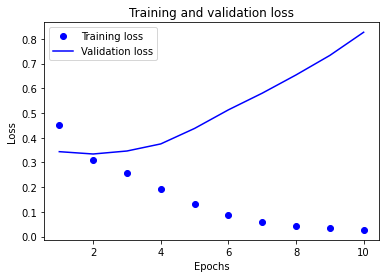

In [28]:
history_dict = history.history

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

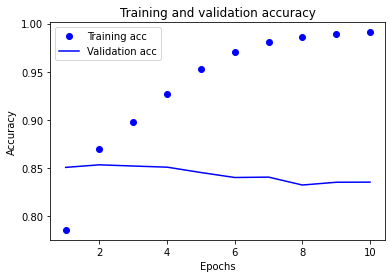

In [29]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

### Embedding

In [30]:
embedding_layer = dcnn_model.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape) 

word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/word2vec.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
vectors = dcnn_model.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)

word_vectors.similar_by_word("사랑")

(10000, 200)


[('-)', 0.672283411026001),
 ('빠져서', 0.6626576781272888),
 ('♥♥♥', 0.6477638483047485),
 ('탁월', 0.644749641418457),
 ('진진', 0.643276572227478),
 ('나무랄', 0.6425375938415527),
 ('쵝오', 0.6403668522834778),
 ('♥♥', 0.6400318145751953),
 ('넘사벽', 0.6384033560752869),
 ('예뻐요', 0.6353152990341187)]

> lstm보다는 '사랑'이라는 단어와 비슷한 단어들이 몇개 나온 것 같다

### 한국어 Word2Vec

In [31]:
word2vec_path = os.getenv('HOME')+'/aiffel/sentiment_classification/ko.bin'
word2vec = gensim.models.Word2Vec.load(word2vec_path)

word2vec.wv.similar_by_word("감동")

[('감명', 0.7177015542984009),
 ('감격', 0.6908231973648071),
 ('실망', 0.6267645359039307),
 ('감화', 0.6191877126693726),
 ('감탄', 0.6140128374099731),
 ('칭찬', 0.6059398055076599),
 ('존경', 0.6032299995422363),
 ('자극', 0.594598650932312),
 ('감복', 0.5902734994888306),
 ('호응', 0.5850393772125244)]

In [32]:
vocab_size = 10000
word_vector_dim = 200

embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

for i in range(4,vocab_size):
    if index_to_word[i] in word2vec.wv:
        embedding_matrix[i] = word2vec.wv[index_to_word[i]]

In [33]:
vocab_size = 10000
word_vector_dim = 200

conv1d_ko = keras.Sequential()
conv1d_ko.add(keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),
                                 input_length=maxlen, 
                                 trainable=True))
conv1d_ko.add(keras.layers.Conv1D(16, 7, activation='relu'))
conv1d_ko.add(keras.layers.MaxPooling1D(5))
conv1d_ko.add(keras.layers.Conv1D(16, 7, activation='relu'))
conv1d_ko.add(keras.layers.GlobalMaxPooling1D())
conv1d_ko.add(keras.layers.Dense(8, activation='relu'))
conv1d_ko.add(keras.layers.Dense(1, activation='sigmoid'))

conv1d_ko.summary()


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 41, 200)           2000000   
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 35, 16)            22416     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 7, 16)             0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 1, 16)             1808      
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 16)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                

In [34]:
conv1d_ko.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=10

history = conv1d_ko.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/10
227/227 [==============================] - 2s 7ms/step - loss: 0.5422 - accuracy: 0.7159 - val_loss: 0.4366 - val_accuracy: 0.7972
Epoch 2/10
227/227 [==============================] - 1s 6ms/step - loss: 0.3867 - accuracy: 0.8280 - val_loss: 0.3687 - val_accuracy: 0.8369
Epoch 3/10
227/227 [==============================] - 1s 6ms/step - loss: 0.3277 - accuracy: 0.8603 - val_loss: 0.3510 - val_accuracy: 0.8460
Epoch 4/10
227/227 [==============================] - 1s 6ms/step - loss: 0.2934 - accuracy: 0.8781 - val_loss: 0.3606 - val_accuracy: 0.8441
Epoch 5/10
227/227 [==============================] - 1s 6ms/step - loss: 0.2660 - accuracy: 0.8922 - val_loss: 0.3532 - val_accuracy: 0.8495
Epoch 6/10
227/227 [==============================] - 1s 7ms/step - loss: 0.2427 - accuracy: 0.9033 - val_loss: 0.3666 - val_accuracy: 0.8465
Epoch 7/10
227/227 [==============================] - 1s 6ms/step - loss: 0.2216 - accuracy: 0.9128 - val_loss: 0.3781 - val_accuracy: 0.8472
Epoch 

In [35]:
results = conv1d_ko.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 3s - loss: 0.4718 - accuracy: 0.8345
[0.4718053936958313, 0.8345301747322083]


----
----

### (3) GlobalMaxPooling
- 이 방식은 전체 문장 중에서 단 하나의 가장 중요한 단어만 피처로 추출하여 그것으로 문장의 긍정/부정을 평가하는 방식

#### 설계

In [29]:
gmp_model = tf.keras.Sequential()
gmp_model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
gmp_model.add(tf.keras.layers.GlobalMaxPooling1D())
gmp_model.add(tf.keras.layers.Dense(8, activation='relu'))
gmp_model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

gmp_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 16)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 9         
Total params: 160,145
Trainable params: 160,145
Non-trainable params: 0
_________________________________________________________________


#### 학습

In [30]:
gmp_model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=10

history = gmp_model.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/10
227/227 [==============================] - 1s 4ms/step - loss: 0.5952 - accuracy: 0.7573 - val_loss: 0.4480 - val_accuracy: 0.8195
Epoch 2/10
227/227 [==============================] - 1s 3ms/step - loss: 0.3882 - accuracy: 0.8380 - val_loss: 0.3639 - val_accuracy: 0.8408
Epoch 3/10
227/227 [==============================] - 1s 3ms/step - loss: 0.3301 - accuracy: 0.8615 - val_loss: 0.3494 - val_accuracy: 0.8467
Epoch 4/10
227/227 [==============================] - 1s 4ms/step - loss: 0.3001 - accuracy: 0.8758 - val_loss: 0.3476 - val_accuracy: 0.8491
Epoch 5/10
227/227 [==============================] - 1s 3ms/step - loss: 0.2782 - accuracy: 0.8863 - val_loss: 0.3508 - val_accuracy: 0.8498
Epoch 6/10
227/227 [==============================] - 1s 3ms/step - loss: 0.2602 - accuracy: 0.8952 - val_loss: 0.3572 - val_accuracy: 0.8487
Epoch 7/10
227/227 [==============================] - 1s 3ms/step - loss: 0.2451 - accuracy: 0.9029 - val_loss: 0.3648 - val_accuracy: 0.8473
Epoch 

#### 결과

In [31]:
results = gmp_model.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 2s - loss: 0.4125 - accuracy: 0.8365
[0.41248372197151184, 0.8364831209182739]


#### 그래프로 확인

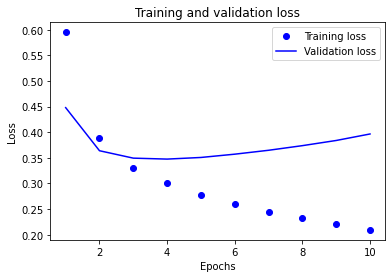

In [32]:
history_dict = history.history

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

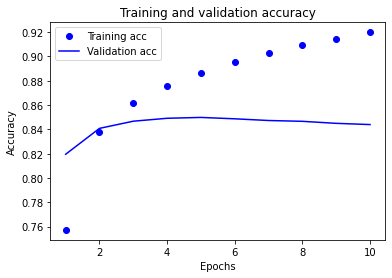

In [33]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

### 한국어 Word2Vec

In [36]:
word2vec_path = os.getenv('HOME')+'/aiffel/sentiment_classification/ko.bin'
word2vec = gensim.models.Word2Vec.load(word2vec_path)

In [37]:
vocab_size = 10000
word_vector_dim = 200

embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

for i in range(4,vocab_size):
    if index_to_word[i] in word2vec.wv:
        embedding_matrix[i] = word2vec.wv[index_to_word[i]]

In [38]:
vocab_size = 10000
word_vector_dim = 200

gmp_ko = keras.Sequential()
gmp_ko.add(keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),
                                 input_length=maxlen, 
                                 trainable=True))
gmp_ko.add(keras.layers.GlobalMaxPooling1D())
gmp_ko.add(keras.layers.Dense(8, activation='relu'))
gmp_ko.add(keras.layers.Dense(1, activation='sigmoid'))

gmp_ko.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 41, 200)           2000000   
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 200)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 8)                 1608      
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 9         
Total params: 2,001,617
Trainable params: 2,001,617
Non-trainable params: 0
_________________________________________________________________


In [39]:
gmp_ko.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=10

history = gmp_ko.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/10
227/227 [==============================] - 2s 5ms/step - loss: 0.7265 - accuracy: 0.5799 - val_loss: 0.6140 - val_accuracy: 0.6635
Epoch 2/10
227/227 [==============================] - 1s 5ms/step - loss: 0.5739 - accuracy: 0.7022 - val_loss: 0.5417 - val_accuracy: 0.7250
Epoch 3/10
227/227 [==============================] - 1s 4ms/step - loss: 0.5109 - accuracy: 0.7513 - val_loss: 0.4954 - val_accuracy: 0.7594
Epoch 4/10
227/227 [==============================] - 1s 4ms/step - loss: 0.4678 - accuracy: 0.7795 - val_loss: 0.4634 - val_accuracy: 0.7807
Epoch 5/10
227/227 [==============================] - 1s 4ms/step - loss: 0.4355 - accuracy: 0.8005 - val_loss: 0.4425 - val_accuracy: 0.7938
Epoch 6/10
227/227 [==============================] - 1s 4ms/step - loss: 0.4091 - accuracy: 0.8154 - val_loss: 0.4278 - val_accuracy: 0.8018
Epoch 7/10
227/227 [==============================] - 1s 4ms/step - loss: 0.3891 - accuracy: 0.8256 - val_loss: 0.4171 - val_accuracy: 0.8092
Epoch 

In [40]:
results = gmp_ko.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 2s - loss: 0.4123 - accuracy: 0.8135
[0.4123106598854065, 0.8134751915931702]


----
----

### (4) 양방향 LSTM
- 양방향 LSTM 또는 BiLSTM은 두 개의 LSTM으로 구성된 시퀀스 처리 모델
- 하나는 입력을 순방향으로, 다른 하나는 역방향으로 사용
- BiLSTM은 네트워크에서 사용할 수 있는 정보의 양을 효과적으로 증가시켜 알고리즘에서 사용할 수 있는 컨텍스트를 개선

In [48]:
from keras.models import Sequential
from keras.layers import Embedding, Dense, TimeDistributed, Dropout, Bidirectional

#### 설계

In [50]:
vocab_size = 10000
word_vector_dim = 16

bilstm_model = keras.Sequential()
bilstm_model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
bilstm_model.add(keras.layers.Bidirectional(keras.layers.LSTM(128, return_sequences = False), input_shape = (49,1)))
bilstm_model.add(keras.layers.Dense(64, activation='relu'))
bilstm_model.add(keras.layers.Dense(1, activation='sigmoid'))

bilstm_model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 256)               148480    
_________________________________________________________________
dense_10 (Dense)             (None, 64)                16448     
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 65        
Total params: 324,993
Trainable params: 324,993
Non-trainable params: 0
_________________________________________________________________


#### 학습

In [51]:
bilstm_model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=10

history = bilstm_model.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/10
227/227 [==============================] - 7s 19ms/step - loss: 0.4537 - accuracy: 0.7801 - val_loss: 0.3502 - val_accuracy: 0.8463
Epoch 2/10
227/227 [==============================] - 4s 16ms/step - loss: 0.3378 - accuracy: 0.8564 - val_loss: 0.3567 - val_accuracy: 0.8427
Epoch 3/10
227/227 [==============================] - 4s 16ms/step - loss: 0.3189 - accuracy: 0.8645 - val_loss: 0.3471 - val_accuracy: 0.8491
Epoch 4/10
227/227 [==============================] - 4s 17ms/step - loss: 0.3030 - accuracy: 0.8708 - val_loss: 0.3501 - val_accuracy: 0.8493
Epoch 5/10
227/227 [==============================] - 4s 17ms/step - loss: 0.2870 - accuracy: 0.8767 - val_loss: 0.3496 - val_accuracy: 0.8493
Epoch 6/10
227/227 [==============================] - 4s 17ms/step - loss: 0.2678 - accuracy: 0.8838 - val_loss: 0.3646 - val_accuracy: 0.8502
Epoch 7/10
227/227 [==============================] - 4s 16ms/step - loss: 0.2491 - accuracy: 0.8926 - val_loss: 0.3592 - val_accuracy: 0.8507

#### 결과

In [52]:
results = bilstm_model.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 5s - loss: 0.4237 - accuracy: 0.8438
[0.42365485429763794, 0.843765914440155]


#### 그래프로 확인

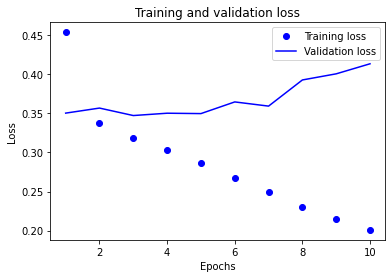

In [53]:
history_dict = history.history

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

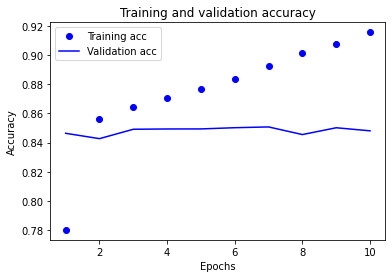

In [54]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

---

## 5. 정리

### (1) 85% 이상
- 정확도를 85% 이상으로 올리기 위해서 LSTM, 1-D CONV, GlobalMaxPooling, BiLSTM 모델에서 하이퍼파라미터를 이것저것 변화시켜 보았지만 85%를 넘는건 생각보다 어려웠다. 
- Word2Vec Embedding 모델을 사용했을 때 LSTM에서만 85%를 간당하게 넘을 수 있었다

![](https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdn%2FZOlTl%2FbtrrB5WFz29%2F54Bt4O3WCZDx8bYKQcaKxk%2Fimg.png)

### (2) Warning 해결
- 4.0.x 버전부터는 vocab이라는 코드가 gensim 패키지 안에서 사라졌기 때문에 gensim의 버전은 3.8.3 으로 다운그레이드 해주었다
- 그러고 사용하니 ' DeprecationWarning: Call to deprecated \`similar_by_word\' '이라는 경고가 떴다
- 일부 버전에서는 사용이 중단되었다 그런내용의 경고라는데 스택오버플로우 덕분에 경고를 해결 할 수 있었다
- https://stackoverflow.com/questions/51791964/deprecationwarning-in-gensim-most-similar

### (3) 느낀점
- 정확도는 대부분 83~84%로 큰 차이가 없었다. 1-D CNN의 validation loss의 경우 갑자기 증가하는걸 볼 수 있는데 그 이유는 잘 모르겠다.. 하이퍼파라미터의 문제인가 싶다..! 모델들의 하이퍼파라미터를 아무리 변화시켜도 85%를 넘기기는 쉽지 않았다. 언어의 문제인가 싶기도 하다. 요즘 부쩍이나 줄임말이나 은어를 많이 사용해서 아무래도 한국어가 영어보다 더 어렵지 않을까 생각한다. 
- 이번 프로젝트가 NLP를 2번째로 접한 프로젝트인데 처음에 접했을 때 보다는 재미있었던 프로젝트인것 같다. 초반보다는 딥러닝 설계가 익숙하지만 아직도 하이퍼파라미터 값을 어떻게 얼마나 넣어야하는지는 잘 몰라서 이것저것 막 넣어본다. 가끔은 이렇게 넣어도 되나 싶을 정도로 넣어보는데 경험이 쌓이면 좀 달라질거라 생각한다.
- 네이버 영화리뷰 자체도 믿을만한 데이터인지 의심이 된다. 조원분이 알려주셔서 알았는데 망작에 일부로 평점과 평을 좋게 써주는 영화들이 있다고 한다. 이런 리뷰가 긍정으로 들어가면 안되는게 아닌가.. 한국어의 반어법이나 비꼬는 말들.. 언어가 문제인것같다 :)